In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

2023-06-13 09:19:58.009779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# the training set contains 60,000 grayscale images, each 28x28 pixels
X_train_full.shape

(60000, 28, 28)

In [4]:
# we want to split the full training set into a validation set and a (smaller) training set we can also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.0
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

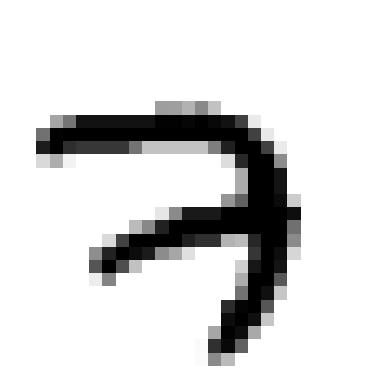

In [5]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [7]:
X_valid.shape

(5000, 28, 28)

In [8]:
X_test.shape

(10000, 28, 28)

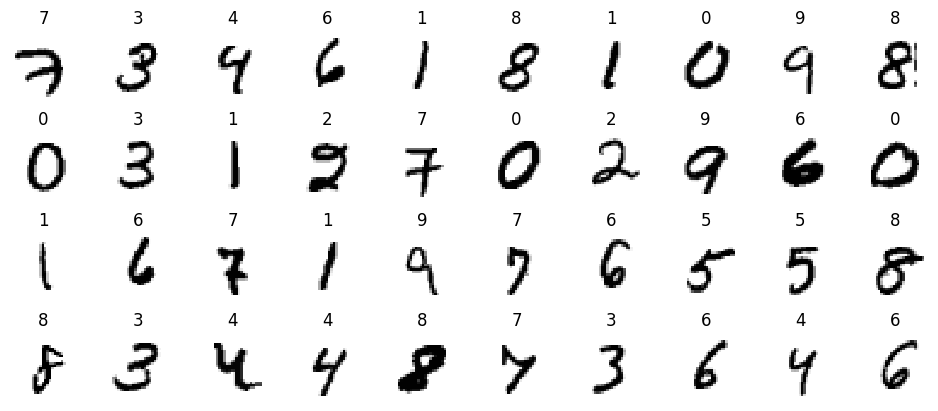

In [9]:
# we want to take a look at a sample of the images
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
# we are building a simple dense network we need a callback to grow the learning rate at each iteration it will also record the learning rate and the loss at each iteration
K = tf.keras.backend


class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(
            self.model.optimizer.learning_rate,
            self.model.optimizer.learning_rate * self.factor,
        )

In [11]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [13]:
# we want to start with a small learning rate of 1e-3 and grow it by 0.5% at each iteration
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
exponential_lr = ExponentialLearningRate(factor=1.005)

In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_data=(X_valid, y_valid),
    callbacks=[exponential_lr],
)

1719/1719 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.6107 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

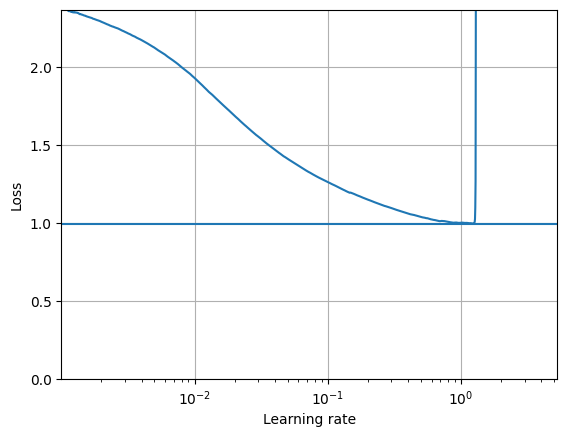

In [15]:
# we can now plot the loss as a function of the learning rate
plt.plot(exponential_lr.rates, exponential_lr.losses)
plt.gca().set_xscale("log")
plt.hlines(
    min(exponential_lr.losses), min(exponential_lr.rates), max(exponential_lr.rates)
)
plt.axis(
    [min(exponential_lr.rates), max(exponential_lr.rates), 0, exponential_lr.losses[0]]
)
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [16]:
# we see that the loss starts to shoot up around 6e-1, so we want to use a learning rate around 3e-1
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [18]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [19]:
run_index = 1  # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [20]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_mnist_model", save_best_only=True
)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
)

Epoch 1/100
1700/1719 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9276

INFO:tensorflow:Assets written to: my_mnist_model/assets


INFO:tensorflow:Assets written to: my_mnist_model/assets


1719/1719 [==============================] - 5s 3ms/step - loss: 0.2339 - accuracy: 0.9280 - val_loss: 0.1008 - val_accuracy: 0.9720
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0944 - accuracy: 0.9707 - val_loss: 0.1148 - val_accuracy: 0.9670
Epoch 3/100
1703/1719 [============================>.] - ETA: 0s - loss: 0.0658 - accuracy: 0.9789

INFO:tensorflow:Assets written to: my_mnist_model/assets


INFO:tensorflow:Assets written to: my_mnist_model/assets


1719/1719 [==============================] - 4s 2ms/step - loss: 0.0657 - accuracy: 0.9789 - val_loss: 0.0820 - val_accuracy: 0.9754
Epoch 4/100
1703/1719 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9833

INFO:tensorflow:Assets written to: my_mnist_model/assets


INFO:tensorflow:Assets written to: my_mnist_model/assets


1719/1719 [==============================] - 4s 3ms/step - loss: 0.0508 - accuracy: 0.9833 - val_loss: 0.0753 - val_accuracy: 0.9790
Epoch 5/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0379 - accuracy: 0.9875 - val_loss: 0.0991 - val_accuracy: 0.9744
Epoch 6/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0259 - accuracy: 0.9919 - val_loss: 0.0765 - val_accuracy: 0.9824
Epoch 7/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0222 - accuracy: 0.9926 - val_loss: 0.0884 - val_accuracy: 0.9796
Epoch 8/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0166 - accuracy: 0.9946 - val_loss: 0.1071 - val_accuracy: 0.9740
Epoch 9/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0142 - accuracy: 0.9953 - val_loss: 0.0922 - val_accuracy: 0.9774
Epoch 10/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0160 - accuracy: 0.9953 - val_loss: 0.0927 - val_accuracy: 0.9

In [21]:
model = tf.keras.models.load_model(
    "my_mnist_model"
)  # this rolls back to the best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 0.0748 - accuracy: 0.9779


[0.07475799322128296, 0.9779000282287598]

In [30]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6752), started 0:04:24 ago. (Use '!kill 6752' to kill it.)

In [31]:
!kill 6752